<a href="https://colab.research.google.com/github/SuperNZH/Deep-Learning-Practice/blob/main/Dive%20in%20DL/4.1_polynomial_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 这个主要研究各种拟合问题
%matplotlib inline
import torch
import numpy as np
import sys

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Dive_in_ML')
import d2lzh_pytorch as d2l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Dataset

In [2]:
# 生成一个基于这个多项式的数据集
# y = 1.2x - 3.4x² + 5.6x³ + 5 + ε  ----> ε是噪声项

n_train, n_test, true_w, true_b = 100, 100, [1.2,-3.4,5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.2868],
         [-0.8235]]), tensor([[ 0.2868,  0.0823,  0.0236],
         [-0.8235,  0.6782, -0.5585]]), tensor([ 5.1985, -1.4305]))

# Define, Train, and Test Model

In [4]:
# 作图函数
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [5]:
# 多项式函数的拟合也用平方损失函数
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了
    
    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

# Third order polynomial function fitting

final epoch: train loss 0.00010869206744246185 test loss 0.0001252511574421078
weight: tensor([[ 1.2031, -3.3993,  5.5990]]) 
bias: tensor([4.9984])


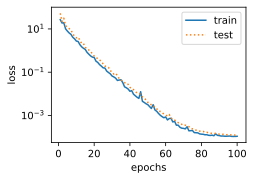

In [6]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

# Linear Function Fitting (Underfitting)

final epoch: train loss 174.81796264648438 test loss 199.3480224609375
weight: tensor([[17.8473]]) 
bias: tensor([2.7461])


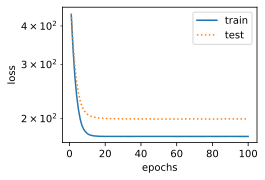

In [7]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

# 

# Insufficient Training Samples (Overfitting)

final epoch: train loss 3.24406099319458 test loss 356.5688781738281
weight: tensor([[ 2.1545, -0.8549,  0.6417]]) 
bias: tensor([2.3015])


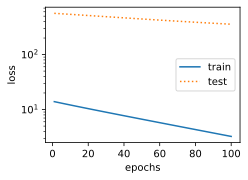

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])